<h1 class=jumbotron>Project</h2>

In [3]:
"""
date: 2.02.19
Что я хочу:
Дан временной ряд. Задана история временного ряда (history_size)
Хочу с какой-то точностью предсказывать следующее значение на шаг вперед
(шаг дикретизации ряда)
Реализовать:
1. Из потока данных формировать
   a) скользящее среднее;
   б) бинарные ряды (f(t)>ma(f(t),f'(t) > 0, f''(t)>0, ...);
   в) гистограммы распределения (см. Histogram)
2. Используя гистограммы формировать прогноз, рассчитывать точность
3. Визуализация
4. Тестирование
5. Оптимизация
6. Production
"""

import numpy as np
import fileinput as fi
import matplotlib as mpl
#mpl.use('GTK3Agg')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from bitarray import bitarray
from zipfile import ZipFile


def ema(series, alpha, ma=None):
    """
     Calculates exponentially weighted moving average  (https://en.wikipedia.org/wiki/Moving_average)
    :param series:
    :param alpha:
    :param ma: ma(t-1)
    :return: generator(ma(t),m(t+1),..ma(t+len(series))

    """
    if not ma:
        ma = series[0]
    for f in series:
        yield alpha*f+(1.-alpha)*ma


def fileStream(files, batch_size=32, *args, **kwargs):
    """
     Generates batches from file lines (expected float number per line)
    :param files:
    :param batch_size:
    :return: numpy.ndarray
    """
    eof = False
    with fi.input(files=files, mode='r', openhook=open_hook) as f:
        while not eof:
            r = []
            for i in range(batch_size):
                line = f.readline()
                if line:
                    try:
                        r.append(float(line))
                    except ValueError as e:
                        print(e, "Couldn't read float")
                else:
                    eof = True
                    break
            yield np.array(r)


def formBinarySeries(stream, *args, **kwargs):
    """

    :param stream: Stream of data (stream of numbers as for beginning)
    :return:
    """
    alpha = kwargs.get('alpha', 0.9)   # coeff of smoothness
    nod = kwargs.get('nod', 2)  # число производных (f'(t),f''(t) as default)
    series = [[]]                         # series = [(ma>f(t),f'(t)>0,f''(t)>0,...] , len(series)=nod+1
    t_1 = [None]                          # previous values [ma(t-1),f(t-1),v(t-1)]
    ma = None
    for i in range(1,nod+1):
        t_1.append(0.0)
        series.append([])
    for batch in stream:
        for i in range(nod+1):
            series[i] = []
        for (ma, f) in zip(ema(batch, alpha=alpha, ma=t_1[0]), batch):
            series[0].append(ma > f)
            fi_dt = f
            for i in range(1, nod+1):
                dfi_dt = fi_dt - t_1[i]
                series[i].append(dfi_dt > 0)
                t_1[i] = fi_dt
                fi_dt = dfi_dt
        t_1[0] = ma
        yield (np.array(bin_s, dtype=bool) for bin_s in series)


def predict()( stream, *args, **kwargs):
    """
        Predicts
    :param args:
    :param kwargs:
    :return:
    """
    # initialization of buffers and histograms
    nod = kwargs.get('nod', 2)
    max_offset = kwargs.get('max_offset', 256)
    bufflength = kwargs.get('bufflength', 8)  # bit length
    dt = np.dtype('uint32')
    hists = []         # гистограмма для скользящих буферов длины 8
    offsets = []       # смещения между появлениями одинаковых послед битов длины 8 (одинак буферов)
    slbuffers = []
    init_buffer = bitarray(bufflength, endian='big')
    init_buffer.setall(False)
    points=[[], []]
    for i in range(nod+1):
        hists.append(np.zeros((2 << bufflength-1, max_offset), dtype=dt))
        offsets.append(np.zeros(2 << bufflength-1, dtype=dt))
        slbuffers.append(init_buffer)
    count = 0
    print('Поехали!')
    #------------
    
    for binseries_batches in formBinarySeries(stream, {'nod': nod}):
        for series in zip(binseries_batches):
            count+=1
            if not (count%100000):
                print('Живем!!',np.sum(hists[0]))
            for i in range(nod+1):
                slbuffers[i].pop(0)
                slbuffers[i].append(ma)
                val_index = int.from_bytes(slbuffers[i].tobytes(), 'big')
                m, time_index = divmod(offsets[i][val_index], max_offset)
                if not m:
                    hists[i][val_index, time_index] += 1
                    #points[0].append(val_index)
                    #points[1].append(time_index)
                offsets[i][val_index] = 0
                offsets[i] += 1
    return hists#,points

def drawHist(hist,title, save=False, *args, **kwargs):
    '''

    :param hist:
    :return:
    '''
    fig,(ax1) = plt.subplots(1,1,figsize=(1, 1))
    fig.set_size_inches(10,10)
    cmap = plt.cm.afmhot_r
    #hist =(hist)/np.sum(hist))
    #norm = cm.colors.Normalize(vmax=np.sum(hist), vmin=0)
    #print(hist)
    #print(np.amax(hist))
    im = ax1.imshow(hist,#interpolation='bilinear',
                    cmap=cmap,
                    origin='lower',
                    extent=[0, 256, 0,256],
                    norm=mpl.colors.LogNorm(vmin=0.0000001, vmax=np.sum(hist)),
                    aspect='auto')
    fig.colorbar(im,cmap=cmap)
    ax1.set(xlabel='time', ylabel='value of buffer',title=title)
    if save:
        fig.savefig('{}.png'.format(title),dpi=100,format='png')
    plt.show()


def open_hook(filename, mode):
    '''

    :param filename:
    :param mode:
    :return:
    '''
    if filename.endswith(('.csv', '.txt')):
        return open(filename, mode)
    if filename.endswith('.zip'):
        try:
            zf = ZipFile(filename)
            return zf.open(filename.replace('.zip', '.csv'),mode=mode)
        except Exception as e:
            raise e





In [4]:
files = ['data/points_s.csv']#['C25600000.zip']
hists = updateHistogram(fileStream(files))

Поехали 0
Живем!! 99981
Живем!! 199965
Живем!! 299950
Живем!! 399929
Живем!! 499918
Живем!! 599901
Живем!! 699888
Живем!! 799878
Живем!! 899855
Живем!! 999838


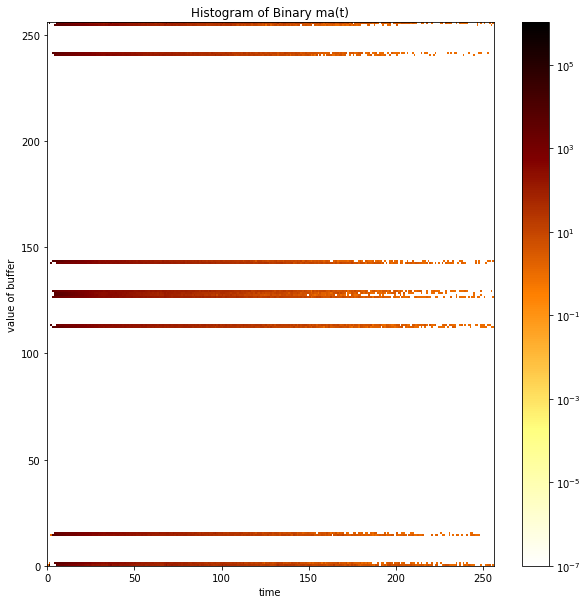

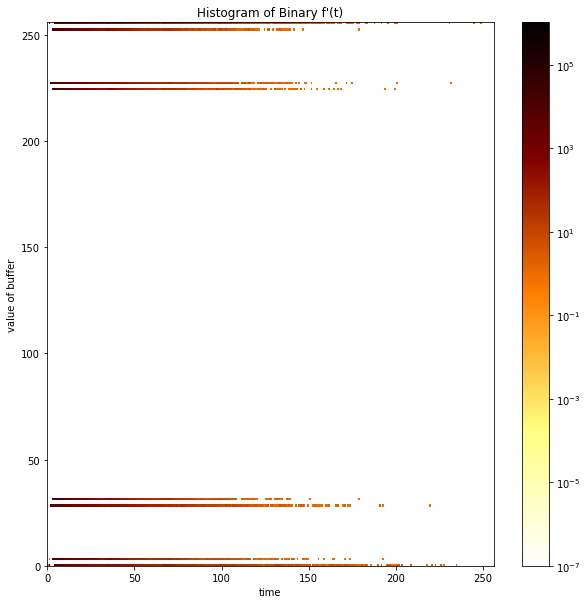

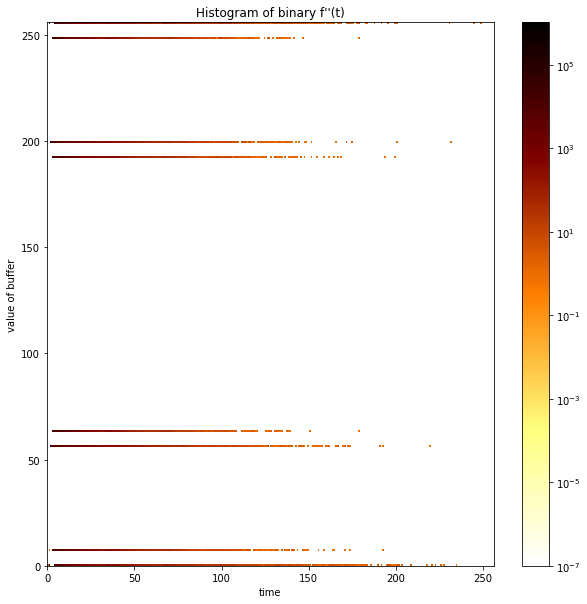

In [5]:
drawHist(hists[0], 'Histogram of Binary ma(t)')
drawHist(hists[1], "Histogram of Binary f'(t)")
drawHist(hists[2], "Histogram of binary f''(t)")